# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis
# Numerical computations and data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical modeling
import statsmodels.api as sm

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

# General settings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv
# Load the dataset into a pandas DataFrame
df = pd.read_csv('porter_data_1.csv')

# Display the first 5 rows of the dataset
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [5]:
# Convert 'created_at' and 'actual_delivery_time' to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

# Verify conversion
df[['created_at', 'actual_delivery_time']].dtypes

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [7]:
# Convert categorical features to category type
# Convert relevant columns to 'category' datatype

# List of categorical columns
categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']

# Convert each to category
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Confirm the datatype changes
df[categorical_cols].dtypes


market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [9]:
# Calculate delivery time in minutes
df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Preview the new column
df[['created_at', 'actual_delivery_time', 'delivery_time']].head()

created_at actual_delivery_time  delivery_time
0 2015-02-06 22:24:17  2015-02-06 23:11:17           47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25           44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35           55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46           59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36           46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [11]:
# Extract the hour of the day
df['order_hour'] = df['created_at'].dt.hour

# Extract the day of the week (0 = Monday, 6 = Sunday)
df['order_dayofweek'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend' (1 for Saturday or Sunday, 0 otherwise)
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [13]:
# Drop unnecessary columns
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

# Preview the updated DataFrame
df[['order_hour', 'order_dayofweek', 'isWeekend']].head()

order_hour  order_dayofweek  isWeekend
0          22                4          0
1          21                1          0
2           0                0          0
3           3                3          0
4           2                1          0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [15]:
# Define target variable (y) and features (X)
# Define target variable
y = df['delivery_time']

# Define input features by dropping the target variable
X = df.drop(columns=['delivery_time'])

# Check the shape of the features and target
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (175777, 15)
Target (y) shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [17]:
# Split data into training and testing sets
# Split the data into training and validation sets (80% - 20%)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display the shape of the resulting splits
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (140621, 15)
X_val shape: (35156, 15)
y_train shape: (140621,)
y_val shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [19]:
# Define categorical and numerical columns in X_train

categorical_cols = X_train.select_dtypes(include='category').columns.tolist() + ['isWeekend', 'order_dayofweek', 'order_hour']
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.difference(['isWeekend', 'order_dayofweek', 'order_hour']).tolist()

# Print the column lists
print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend', 'order_dayofweek', 'order_hour']
Numerical Columns: ['distance', 'max_item_price', 'min_item_price', 'num_distinct_items', 'subtotal', 'total_busy_dashers', 'total_items', 'total_onshift_dashers', 'total_outstanding_orders']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

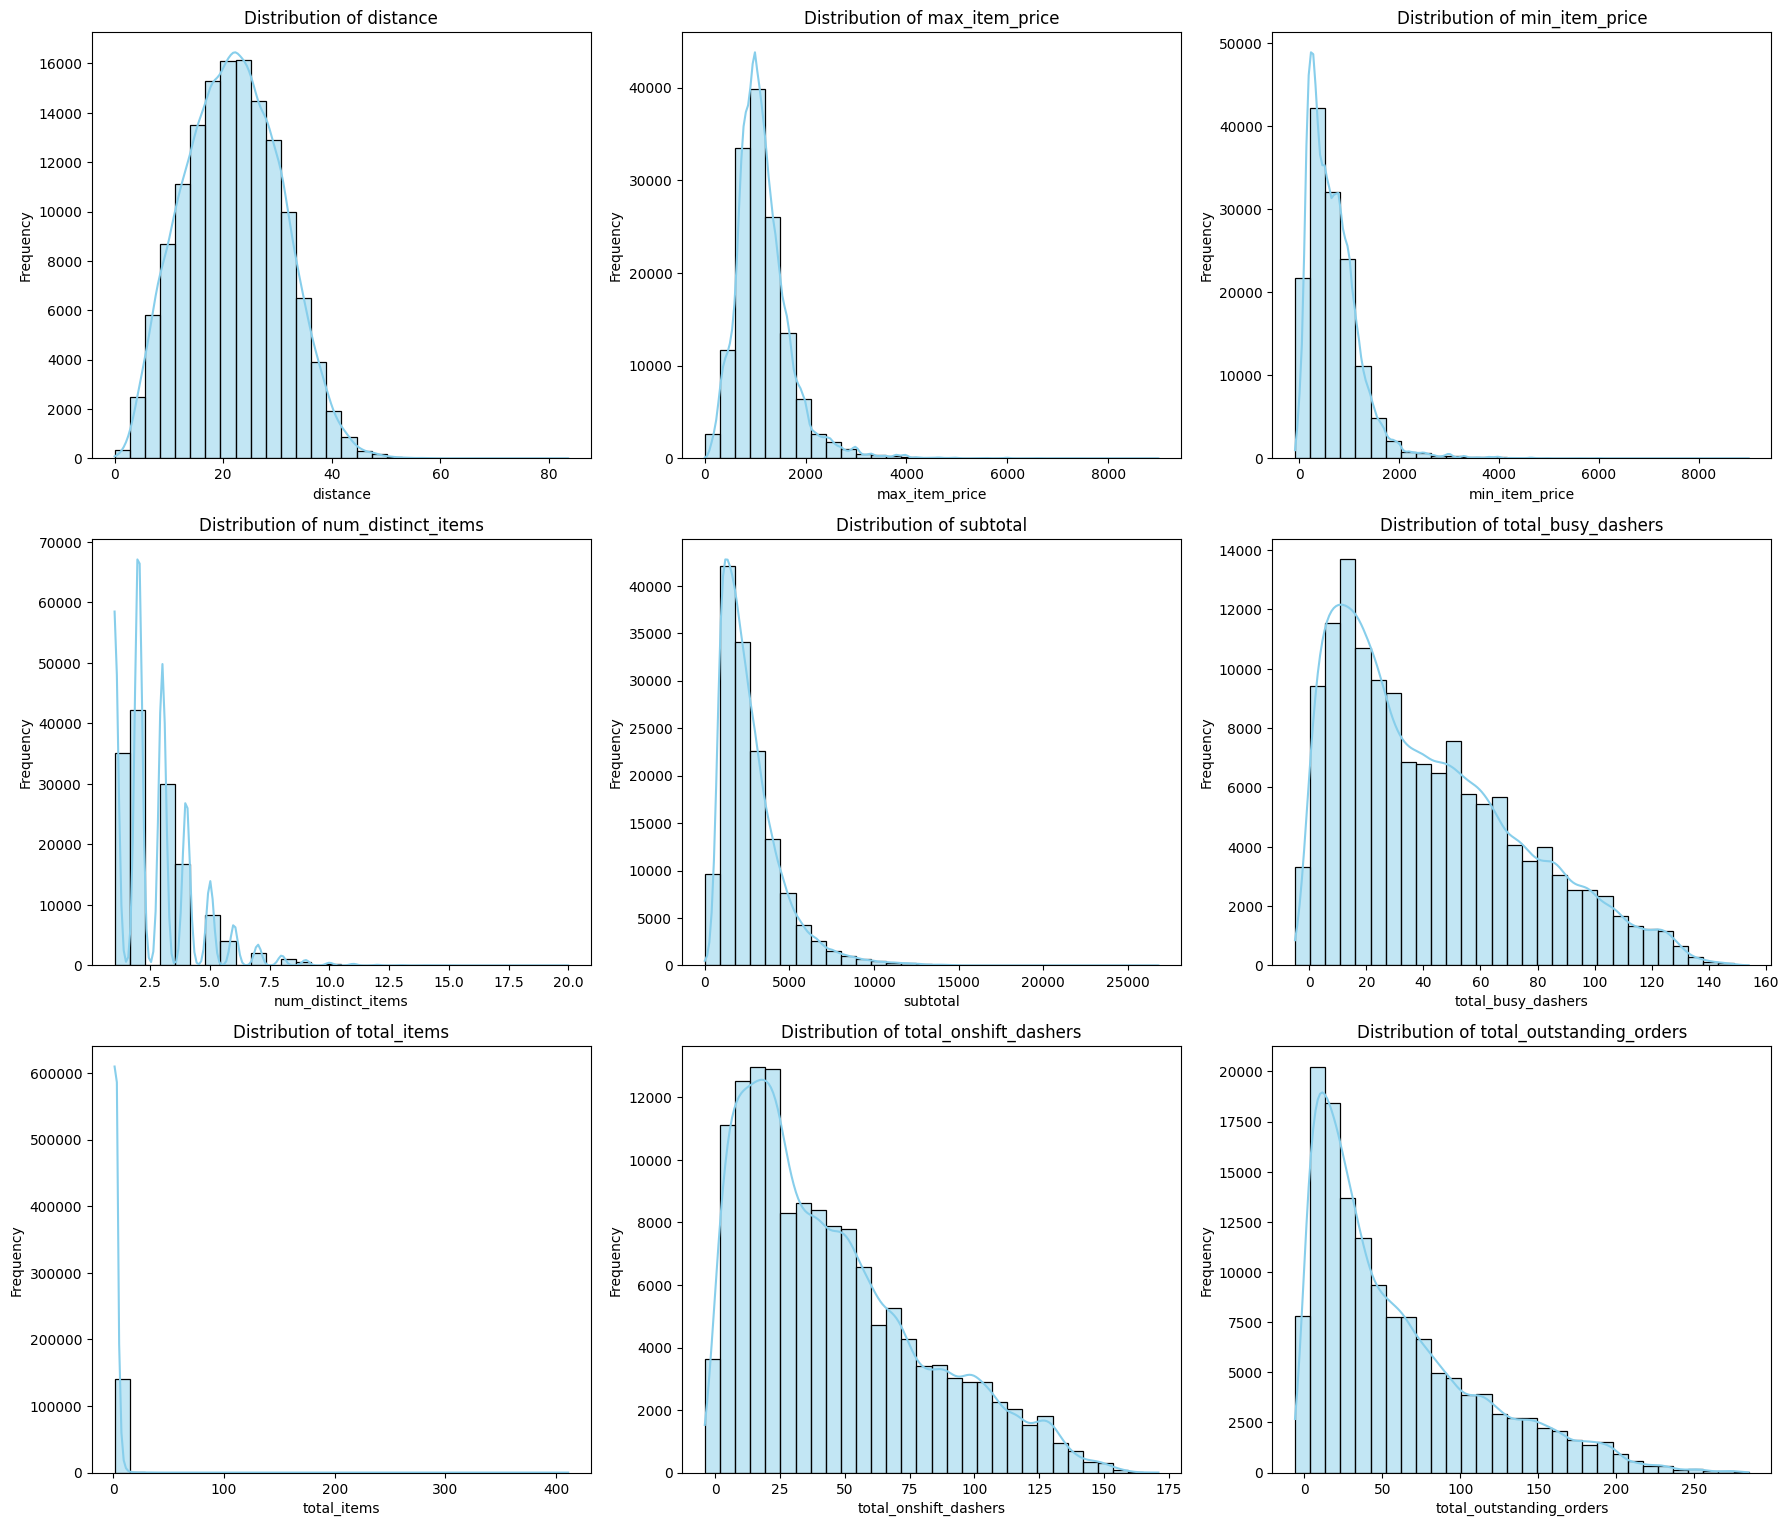

In [21]:
# Plot distributions for all numerical columns
plt.figure(figsize=(18, 20))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 3, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

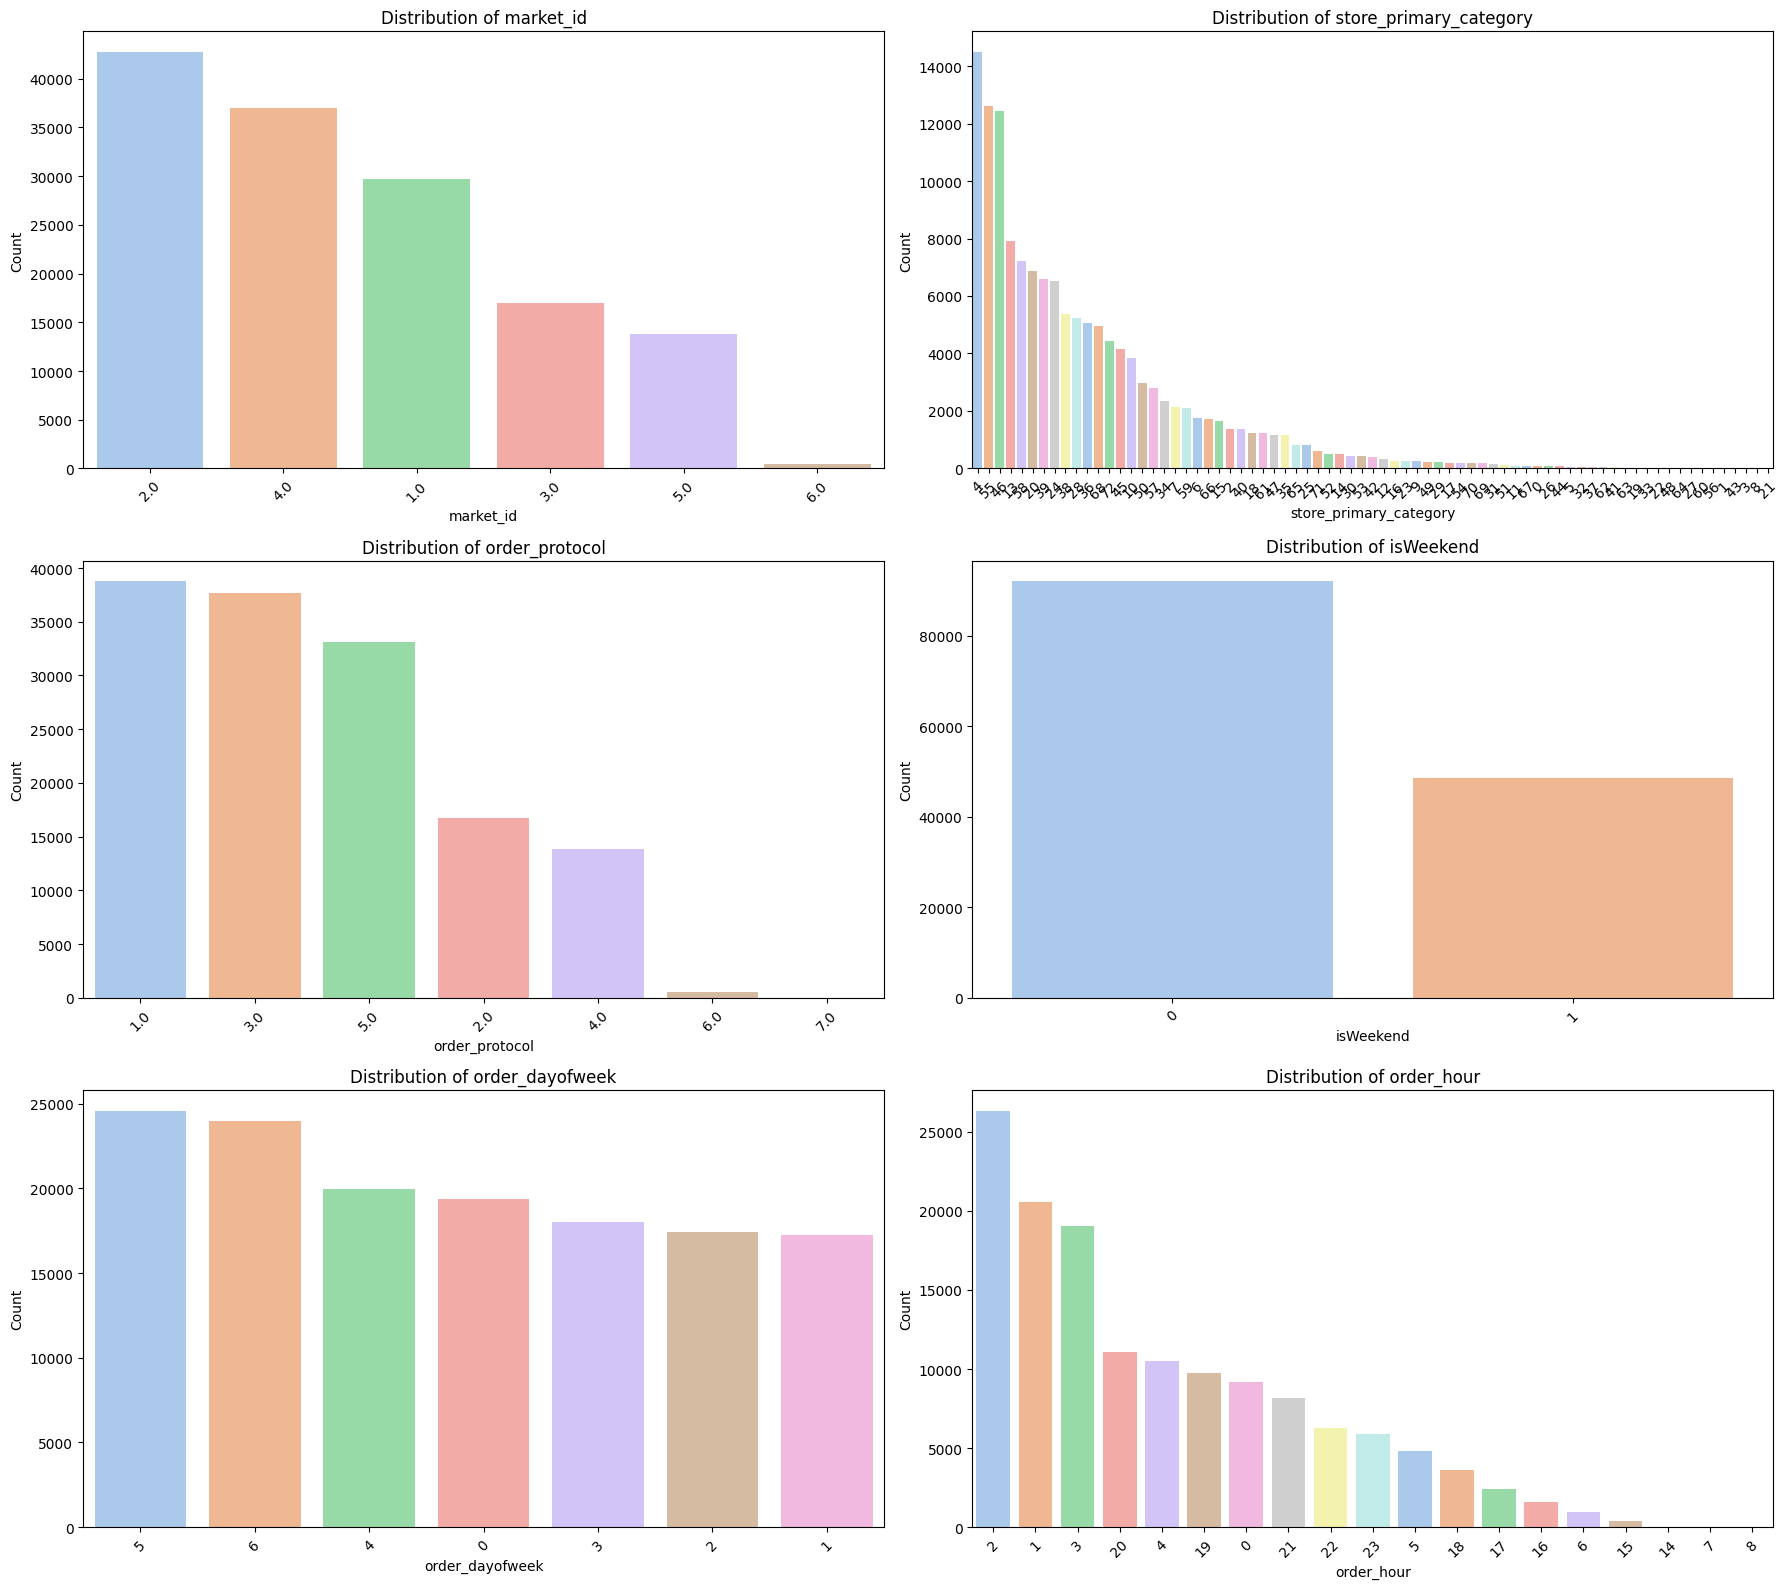

In [24]:
# Distribution of categorical columns

# Set figure size
plt.figure(figsize=(18, 16))

# Plot count plots for each categorical column
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 2, i + 1)
    sns.countplot(data=X_train, x=col, palette='pastel', order=X_train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

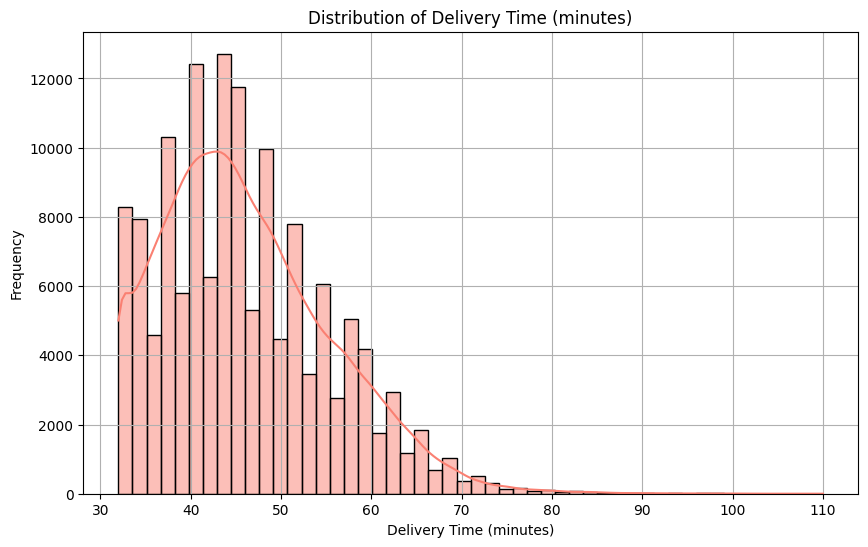

In [26]:
# Distribution of time_taken (i.e., delivery_time)

plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=50, color='salmon')
plt.title('Distribution of Delivery Time (minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

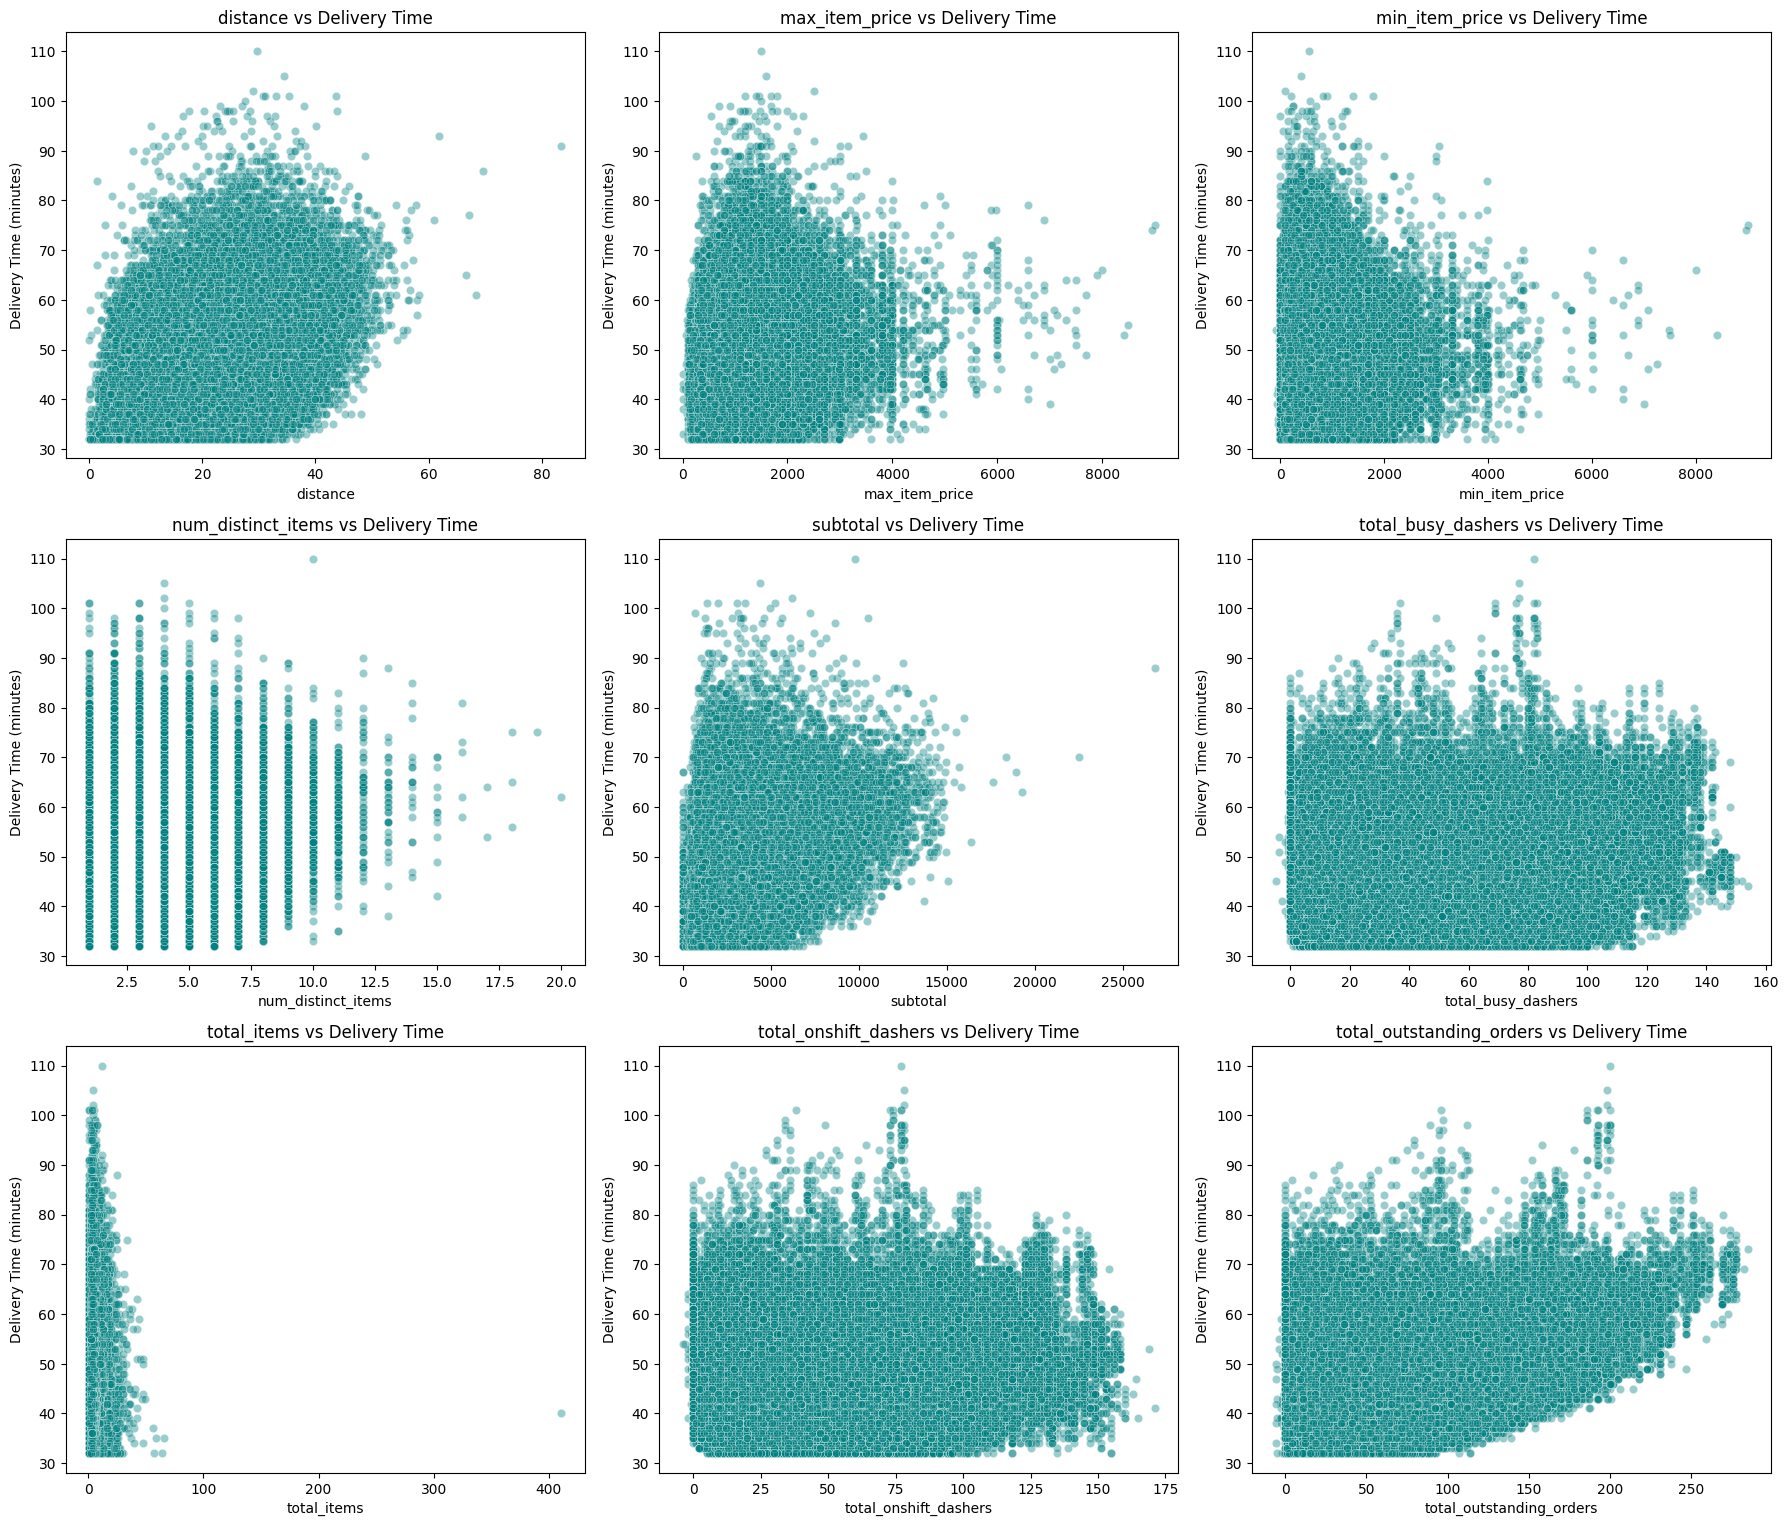

In [28]:
# Scatter plot to visualise the relationship between time_taken and other features

plt.figure(figsize=(18, 20))

# Loop through numerical columns to create scatter plots
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(x=X_train[col], y=y_train, alpha=0.4, color='teal')
    plt.title(f'{col} vs Delivery Time')
    plt.xlabel(col)
    plt.ylabel('Delivery Time (minutes)')

plt.tight_layout()
plt.show()

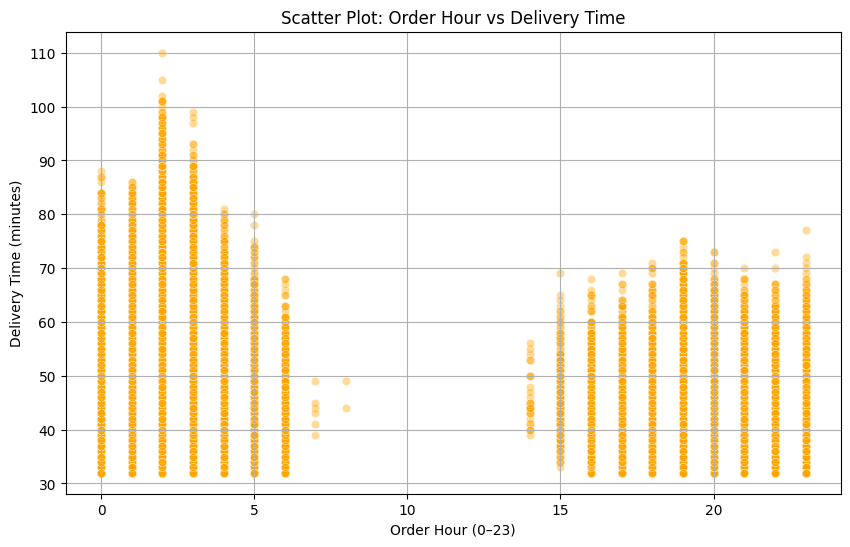

In [32]:
# Show the distribution of delivery_time for different order hours
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train['order_hour'], y=y_train, alpha=0.4, color='orange')
plt.title('Scatter Plot: Order Hour vs Delivery Time')
plt.xlabel('Order Hour (0–23)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

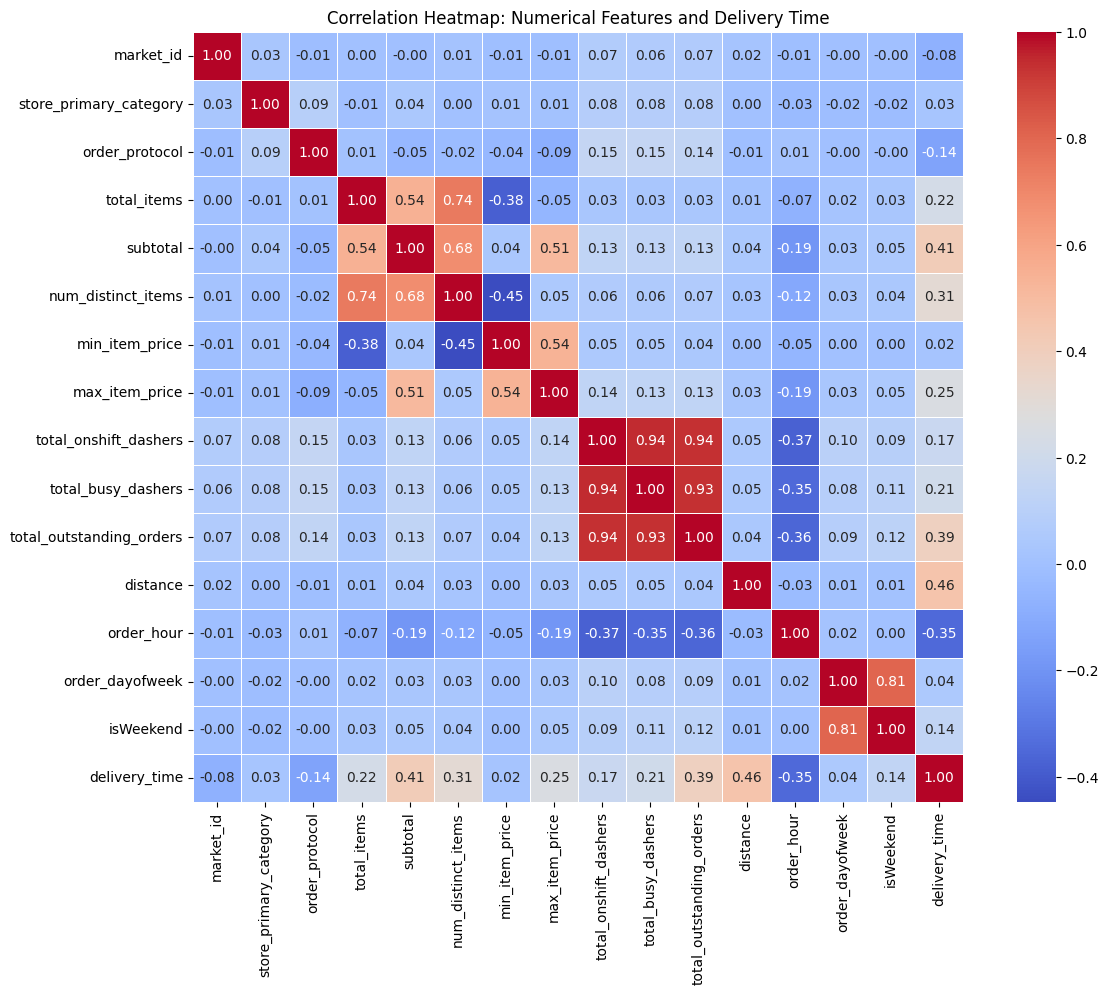

In [35]:
# Plot the heatmap of the correlation matrix
# Combine training features with target for correlation analysis
train_corr_df = X_train.copy()
train_corr_df['delivery_time'] = y_train

# Compute correlation matrix (only numerical features)
corr_matrix = train_corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap: Numerical Features and Delivery Time')
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [38]:
# Drop 3-5 weakly correlated columns from training dataset
# Set a threshold for weak correlation
correlation_threshold = 0.05

# Get correlations with target
target_corr = corr_matrix['delivery_time'].drop('delivery_time')

# Identify weakly correlated features
weak_corr_features = target_corr[abs(target_corr) < correlation_threshold].index.tolist()

print("Dropping these weakly correlated features:", weak_corr_features)

# Drop from train and validation sets
X_train.drop(columns=weak_corr_features, inplace=True)
X_val.drop(columns=weak_corr_features, inplace=True)


Dropping these weakly correlated features: ['store_primary_category', 'min_item_price', 'order_dayofweek']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

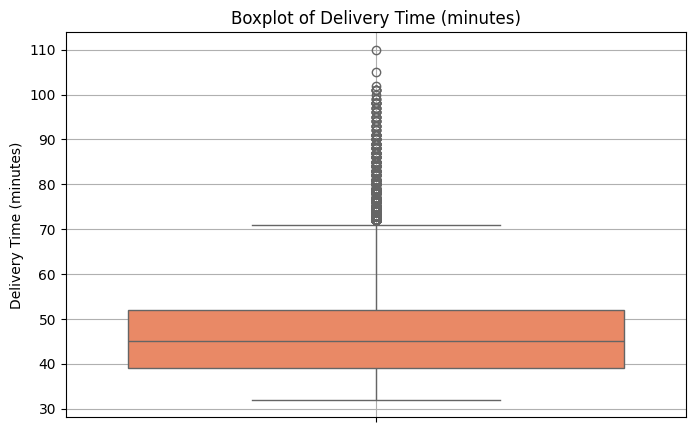

In [40]:
# Boxplot for time_taken (delivery_time)

plt.figure(figsize=(8, 5))
sns.boxplot(y=y_train, color='coral')
plt.title('Boxplot of Delivery Time (minutes)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [42]:
# Handle outliers
# Combine X_train and y_train temporarily for outlier treatment
outlier_df = X_train.copy()
outlier_df['delivery_time'] = y_train

# Get all numerical features (after dropping weak features)
num_features = outlier_df.select_dtypes(include=np.number).columns.tolist()

# Apply IQR-based capping for each numerical column
for col in num_features:
    Q1 = outlier_df[col].quantile(0.25)
    Q3 = outlier_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_df[col] = np.where(outlier_df[col] < lower_bound, lower_bound,
                               np.where(outlier_df[col] > upper_bound, upper_bound, outlier_df[col]))

# Split back into X_train and y_train after outlier handling
X_train = outlier_df.drop(columns='delivery_time')
y_train = outlier_df['delivery_time']

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [44]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Categorical columns (include encoded or derived ones too)
val_categorical_cols = X_val.select_dtypes(include='category').columns.tolist() + ['isWeekend', 'order_hour']

# Numerical columns (excluding categoricals)
val_numerical_cols = X_val.select_dtypes(include=[np.number]).columns.difference(['isWeekend', 'order_hour']).tolist()

# Print to verify
print("Validation Categorical Columns:", val_categorical_cols)
print("Validation Numerical Columns:", val_numerical_cols)

Validation Categorical Columns: ['market_id', 'order_protocol', 'isWeekend', 'order_hour']
Validation Numerical Columns: ['distance', 'max_item_price', 'num_distinct_items', 'subtotal', 'total_busy_dashers', 'total_items', 'total_onshift_dashers', 'total_outstanding_orders']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

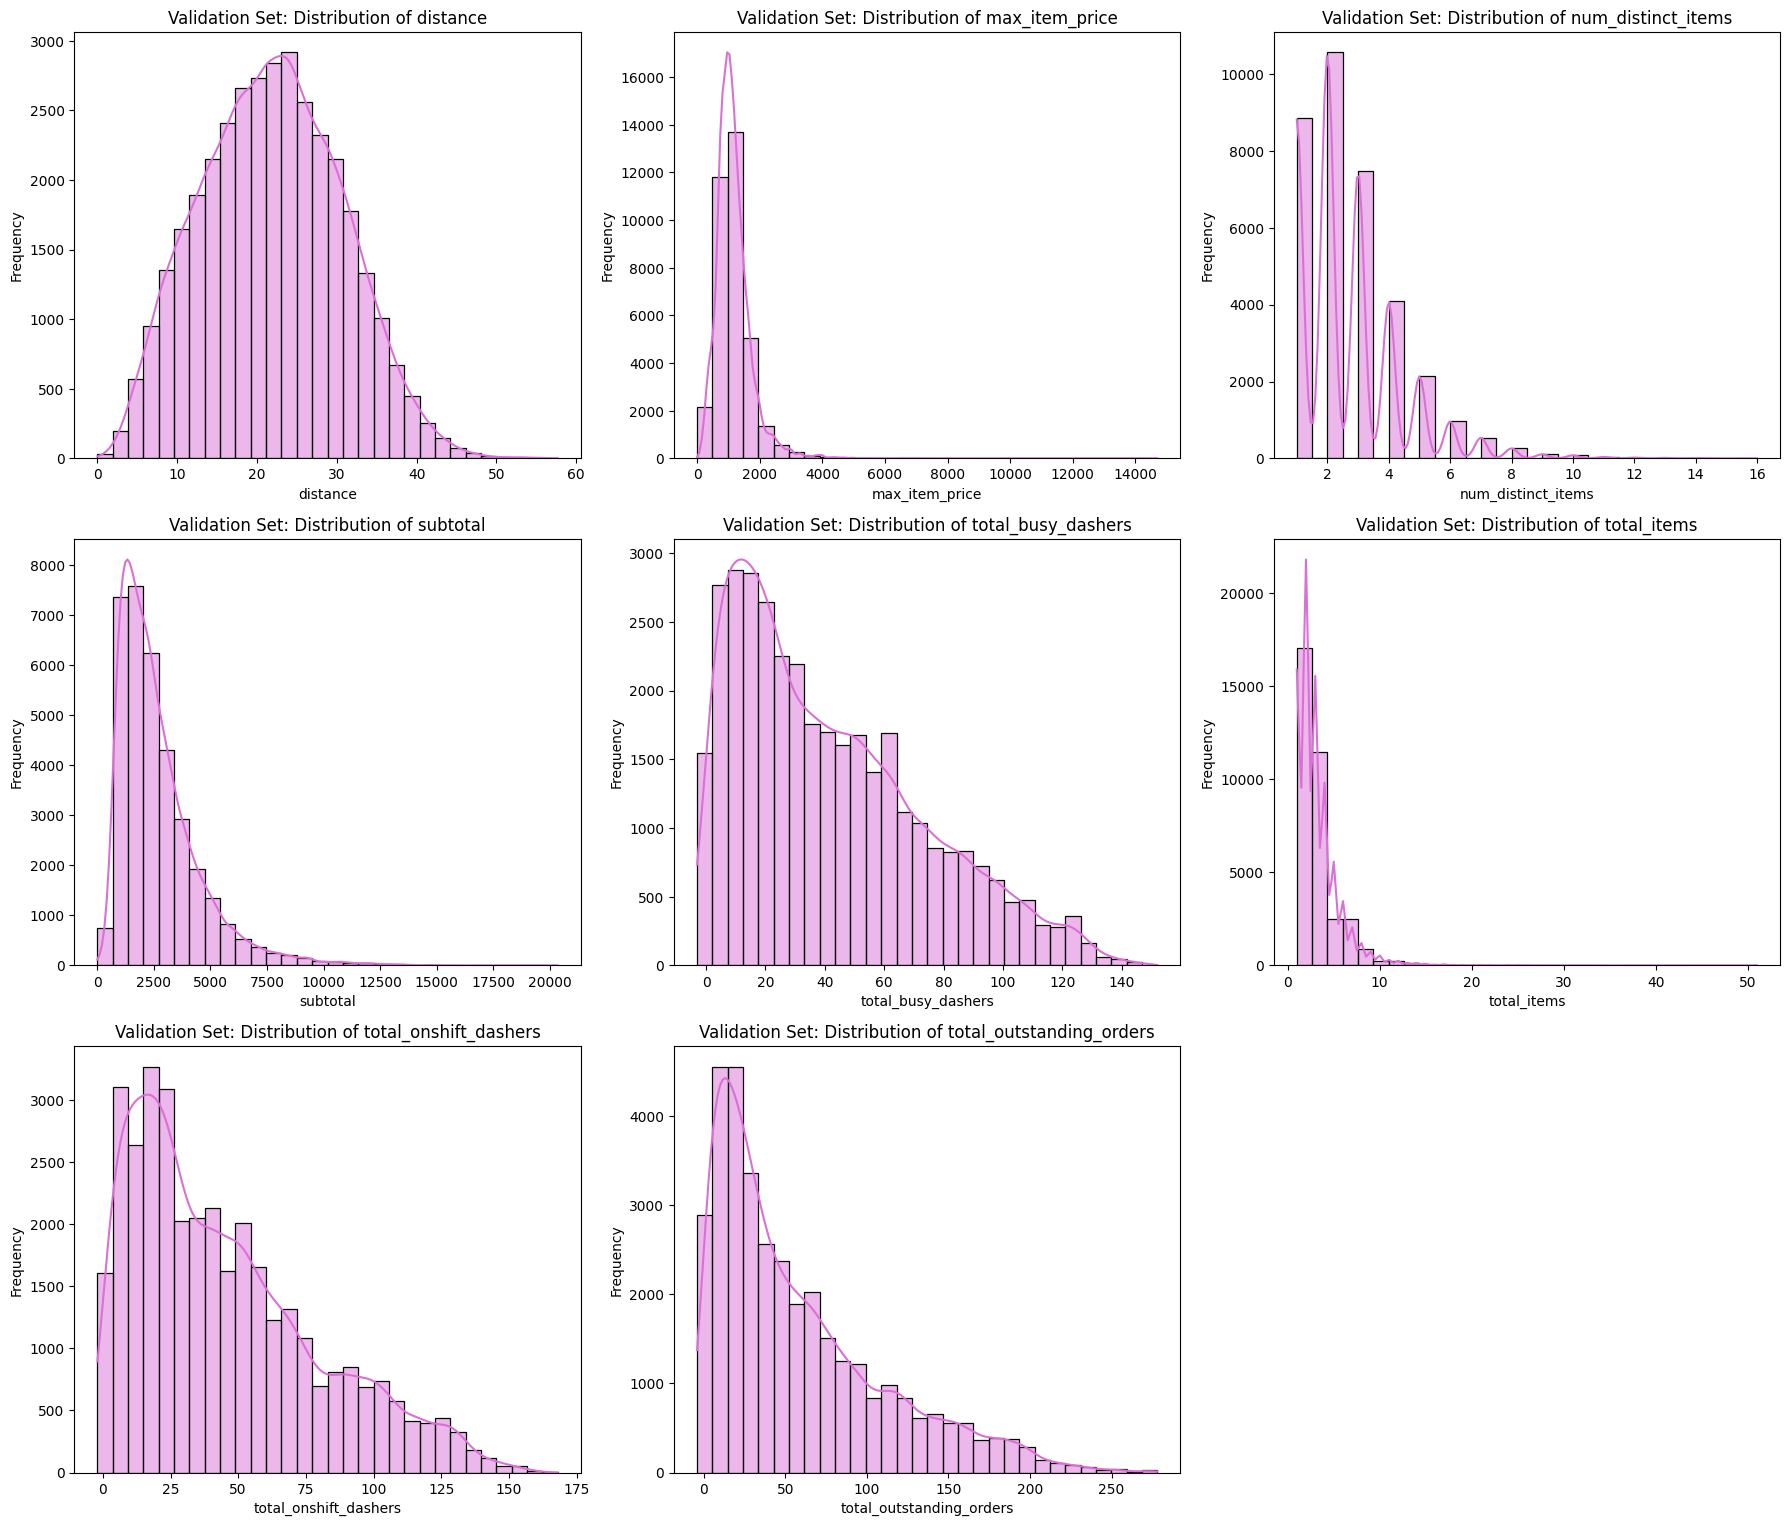

In [46]:
# Plot distributions for all numerical columns
# Plot distributions for all numerical columns in the validation set

plt.figure(figsize=(18, 20))

for i, col in enumerate(val_numerical_cols):
    plt.subplot(4, 3, i + 1)
    sns.histplot(X_val[col], kde=True, bins=30, color='orchid')
    plt.title(f'Validation Set: Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##### **4.1.2**
Check the distribution of categorical features

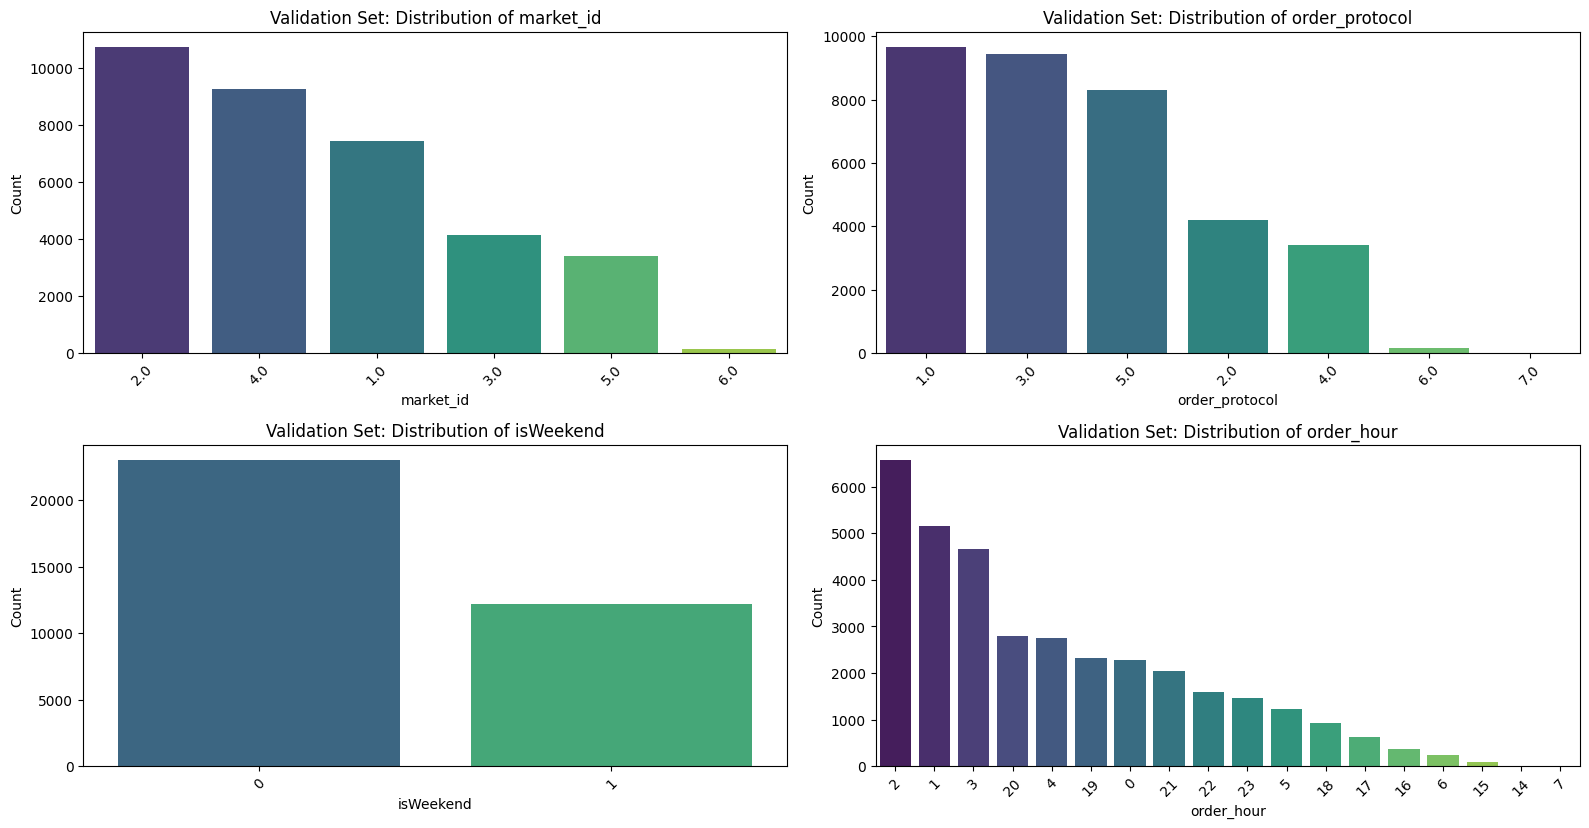

In [48]:
# Distribution of categorical columns
# Distribution of categorical columns in the validation set

plt.figure(figsize=(16, 12))

for i, col in enumerate(val_categorical_cols):
    plt.subplot(3, 2, i + 1)
    sns.countplot(data=X_val, x=col, palette='viridis', order=X_val[col].value_counts().index)
    plt.title(f'Validation Set: Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

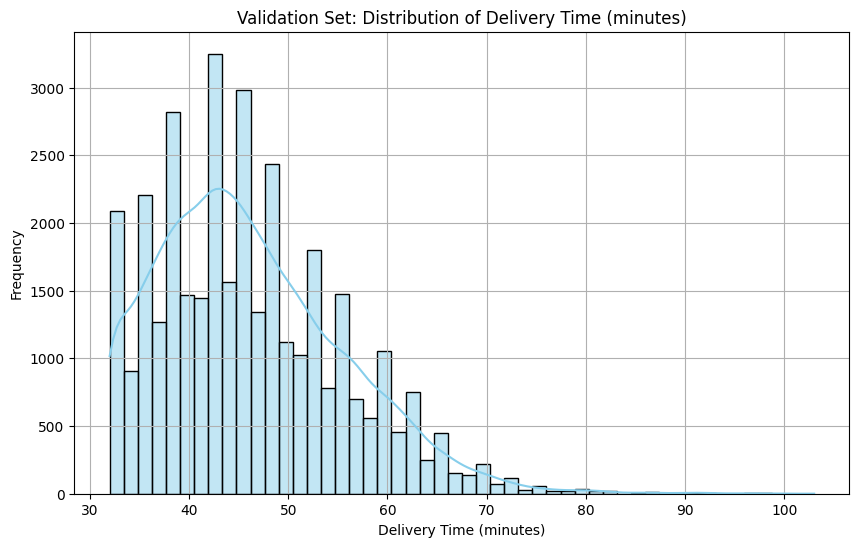

In [50]:
# Distribution of time_taken (delivery_time) in validation set

plt.figure(figsize=(10, 6))
sns.histplot(y_val, kde=True, bins=50, color='skyblue')
plt.title('Validation Set: Distribution of Delivery Time (minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

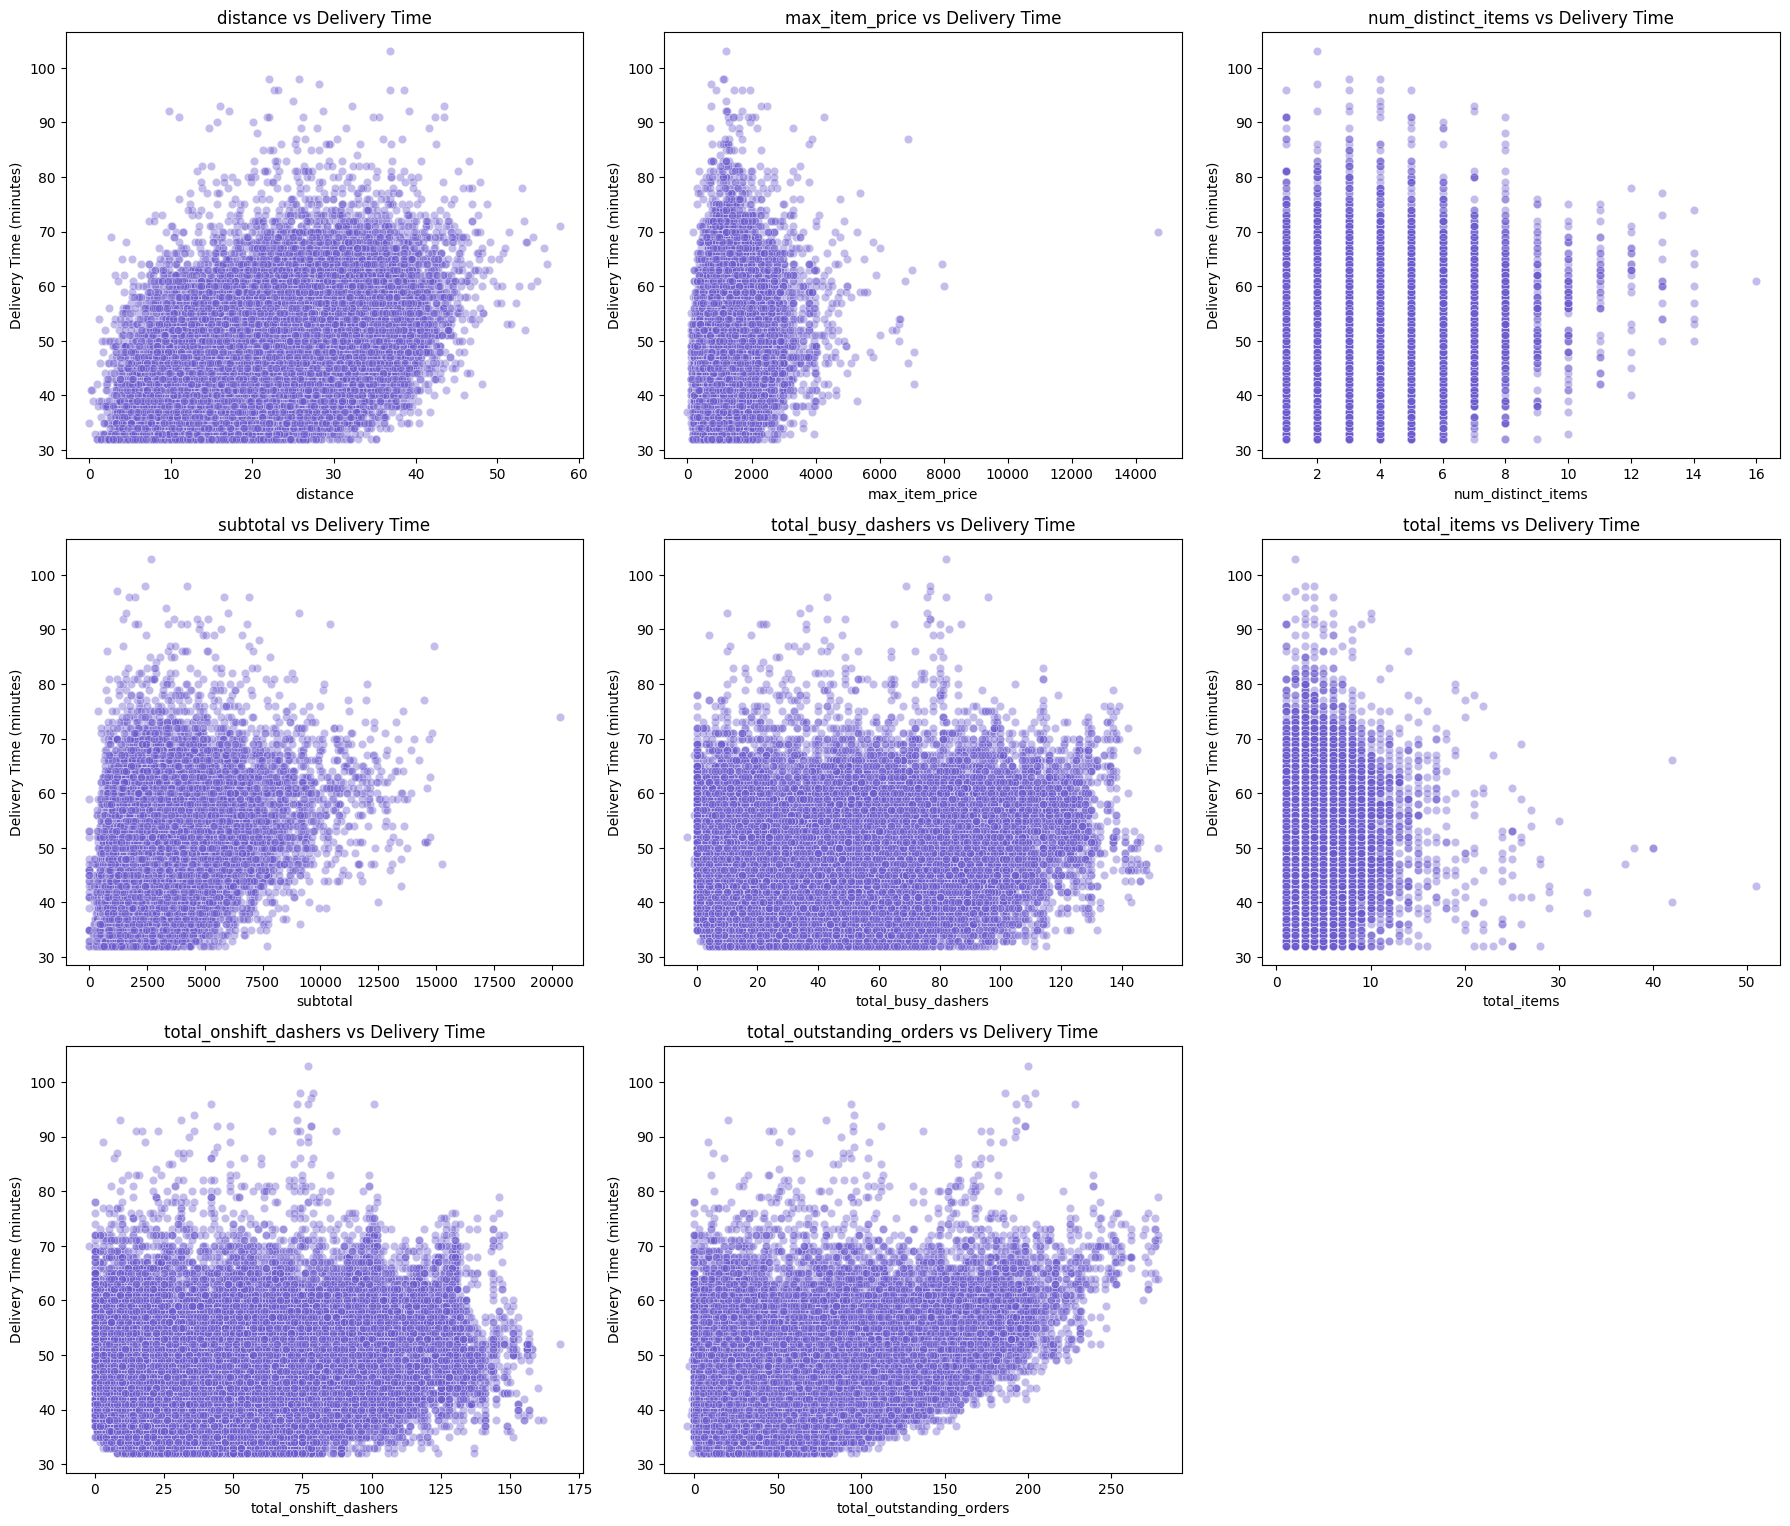

In [52]:
# Scatter plot to visualise the relationship between time_taken and other numerical features (Validation Set)

plt.figure(figsize=(18, 20))

for i, col in enumerate(val_numerical_cols):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(x=X_val[col], y=y_val, alpha=0.4, color='slateblue')
    plt.title(f'{col} vs Delivery Time')
    plt.xlabel(col)
    plt.ylabel('Delivery Time (minutes)')

plt.tight_layout()
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [54]:
# Drop the weakly correlated columns from training dataset
# Drop weakly correlated columns from validation set
columns_to_drop = ['store_primary_category', 'min_item_price', 'order_dayofweek']

# Drop if they exist in X_val
X_val.drop(columns=[col for col in columns_to_drop if col in X_val.columns], inplace=True)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [56]:
# Import libraries
# Model Building: Import necessary libraries

# Linear regression model
from sklearn.linear_model import LinearRegression

# Feature scaling
from sklearn.preprocessing import StandardScaler

# Feature selection
from sklearn.feature_selection import RFE

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [58]:
# Apply scaling to the numerical columns

# Identify numerical columns to scale
scaled_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and validation sets
X_train[scaled_features] = scaler.fit_transform(X_train[scaled_features])
X_val[scaled_features] = scaler.transform(X_val[scaled_features])

# Preview scaled data
X_train[scaled_features].head()

total_items  subtotal  num_distinct_items  max_item_price  \
102712    -1.149075 -1.166865           -1.250913       -0.838500   
94576     -1.149075 -1.052738           -1.250913       -0.300282   
49784      0.559700 -0.371242            1.256041       -0.515569   
37753     -0.579483 -0.152120           -0.415261        0.569478   
91728     -1.149075 -0.769053           -1.250913        0.399401   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
102712              -0.286914           -0.089125                 -0.030878   
94576                1.891894            0.937172                  1.149937   
49784               -1.129387           -1.208721                 -0.995211   
37753               -0.838879           -0.773323                 -0.759048   
91728                0.555558            0.159675                 -0.109599   

        distance  order_hour  isWeekend  
102712  0.971786    1.443320  -0.726493  
94576   1.067993   -0.746310  -0.726493  
49784  -0.420926    1.443320  -0.726493  
37753   1.329126   -0.631067  -0.726493  
91728   1.113806    1.443320  -0.726493

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [60]:
# Create/Initialise the model
linreg = LinearRegression()

# Fit the model to the training data
linreg.fit(X_train, y_train)

# Predict on the validation set
y_pred = linreg.predict(X_val)

# Evaluate the model
r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)

# Print performance metrics
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

R² Score: 0.8722
Mean Squared Error (MSE): 11.19


In [62]:
# Train the model using the training data
# Train the Linear Regression model using the training data

# Initialize the model
linreg = LinearRegression()

# Fit the model on training features and target
linreg.fit(X_train, y_train)

# Print model coefficients and intercept (optional for review)
print("Intercept:", linreg.intercept_)
print("Number of Features Used:", len(X_train.columns))


Intercept: 49.88693520852981
Number of Features Used: 12


In [68]:
# Make predictions
# Make predictions on the validation set
y_pred = linreg.predict(X_val)

# Find results for evaluation metrics
r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)

In [70]:
# Find results for evaluation metrics
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

R² Score: 0.8722
Mean Squared Error (MSE): 11.19


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

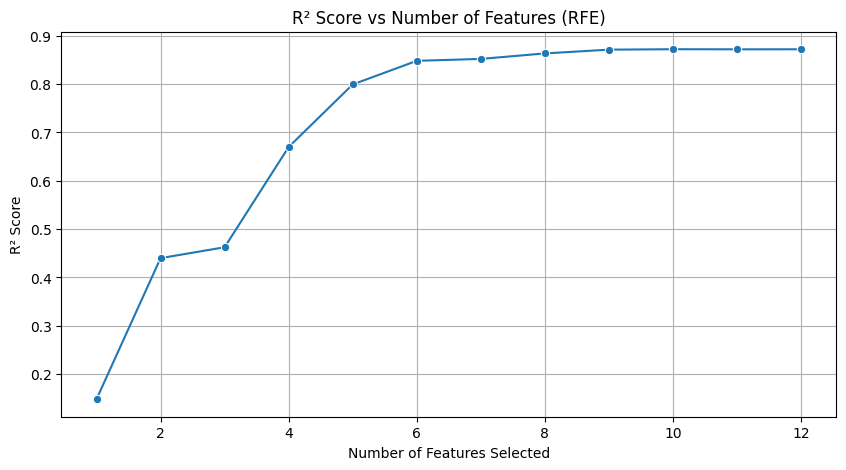

In [72]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store R² scores for different feature counts
rfe_scores = []

# Try from 1 to total number of features
for n in range(1, X_train.shape[1] + 1):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n)
    rfe.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred_rfe = rfe.predict(X_val)
    
    # Store number of features and R² score
    rfe_scores.append((n, r2_score(y_val, y_pred_rfe)))

# Convert to DataFrame
rfe_df = pd.DataFrame(rfe_scores, columns=['Num_Features', 'R2_Score'])

# Plot R² score vs number of features
plt.figure(figsize=(10, 5))
sns.lineplot(data=rfe_df, x='Num_Features', y='R2_Score', marker='o')
plt.title('R² Score vs Number of Features (RFE)')
plt.xlabel('Number of Features Selected')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

In [74]:
# Build the final model with selected number of features (e.g., 8)

# Initialize Linear Regression model
model = LinearRegression()

# Apply RFE to select top 8 features
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X_train, y_train)

# Get mask of selected features
selected_mask = rfe.support_

# Get the selected feature names
selected_features = X_train.columns[selected_mask].tolist()
print("Selected Features:", selected_features)

# Train model on selected features
model.fit(X_train[selected_features], y_train)

# Predict on validation set
y_pred_final = model.predict(X_val[selected_features])

# Evaluate the final model
final_r2 = r2_score(y_val, y_pred_final)
final_mse = mean_squared_error(y_val, y_pred_final)

print(f"\nFinal Model Performance with 8 Features:")
print(f"R² Score: {final_r2:.4f}")
print(f"Mean Squared Error: {final_mse:.2f}")

Selected Features: ['order_protocol', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend']

Final Model Performance with 8 Features:
R² Score: 0.8636
Mean Squared Error: 11.94


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

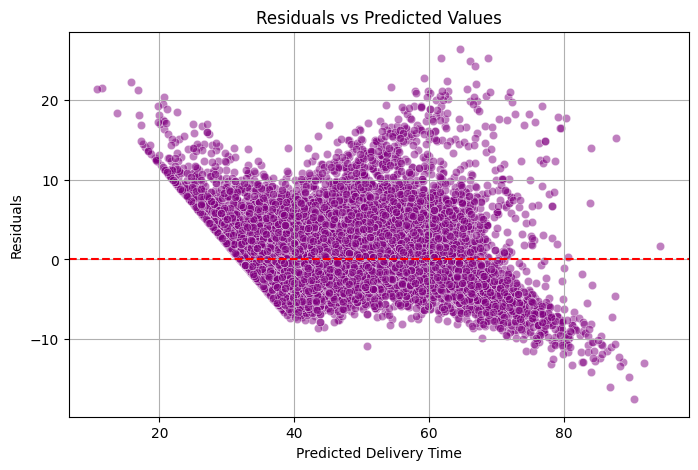

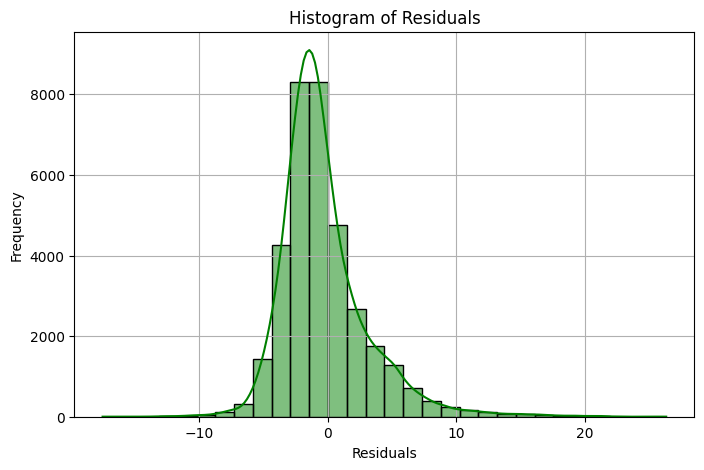

<Figure size 600x600 with 0 Axes>

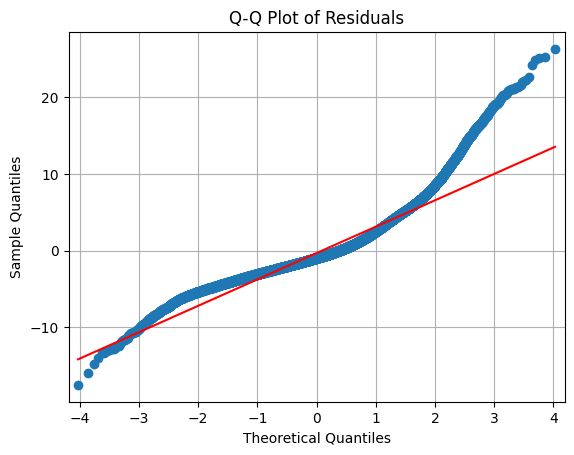

In [76]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

import statsmodels.api as sm

# Calculate residuals
residuals = y_val - y_pred_final

# 1. Residuals vs Predicted Values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Delivery Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='green')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Q-Q Plot of Residuals
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [79]:
# Compare the scaled vs unscaled features used in the final model

# Get coefficients from the scaled model
scaled_coefs = pd.Series(model.coef_, index=selected_features)

# Prepare unscaled data (original, before scaling)
X_unscaled = df[selected_features]
y_unscaled = df['delivery_time']

# Train-validation split for unscaled data
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_unscaled, y_unscaled, test_size=0.2, random_state=42)

# Fit a new model on unscaled data
linreg_unscaled = LinearRegression()
linreg_unscaled.fit(X_train_us, y_train_us)

# Get coefficients from unscaled model
unscaled_coefs = pd.Series(linreg_unscaled.coef_, index=selected_features)

# Create a comparison DataFrame
coef_comparison = pd.DataFrame({
    'Scaled Coefficient': scaled_coefs,
    'Unscaled Coefficient': unscaled_coefs
})

# Display the comparison
coef_comparison.sort_values(by='Scaled Coefficient', ascending=False)

Scaled Coefficient  Unscaled Coefficient
total_outstanding_orders           18.113598              0.347273
distance                            4.098272              0.475332
subtotal                            2.871141              0.001654
isWeekend                           0.783745              1.261935
order_protocol                     -0.680341             -0.669308
order_hour                         -2.076023             -0.254447
total_busy_dashers                 -4.305919             -0.140189
total_onshift_dashers             -12.703751             -0.365169

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [85]:
# Analyze the effect of a unit change in each selected feature

# Step 1: Filter numerical features from selected_features
numerical_selected = df[selected_features].select_dtypes(include=[np.number]).columns.tolist()

# Step 2: Get standard deviations of only numerical features
stds = df[numerical_selected].std()

# Step 3: Extract scaled coefficients of the same numerical features
scaled_coef_numerical = pd.Series(model.coef_, index=selected_features)[numerical_selected]

# Step 4: Calculate effect of 1-unit increase in real world
unit_change_effects = scaled_coef_numerical * stds

# Step 5: Create a comparison table
unit_effect_df = pd.DataFrame({
    'Standard Deviation': stds,
    'Scaled Coefficient': scaled_coef_numerical,
    'Effect of 1 Unit Increase (minutes)': unit_change_effects
})

# Sort by absolute effect
unit_effect_df = unit_effect_df.reindex(unit_effect_df['Effect of 1 Unit Increase (minutes)'].abs().sort_values(ascending=False).index)

unit_effect_df

Standard Deviation  Scaled Coefficient  \
subtotal                         1828.554893            2.871141   
total_outstanding_orders           52.731043           18.113598   
total_onshift_dashers              34.544724          -12.703751   
total_busy_dashers                 32.168505           -4.305919   
distance                            8.748712            4.098272   
order_hour                          8.676809           -2.076023   
isWeekend                           0.475569            0.783745   

                          Effect of 1 Unit Increase (minutes)  
subtotal                                          5250.038352  
total_outstanding_orders                           955.148931  
total_onshift_dashers                             -438.847582  
total_busy_dashers                                -138.514973  
distance                                            35.854599  
order_hour                                         -18.013256  
isWeekend                                            0.372725

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes, the dataset contains several categorical variables such as `market_id`, `store_primary_category`, and `order_protocol`.  
>  
> Additionally, derived features like `order_hour` and `isWeekend` were also treated as categorical during analysis.  
>  
> From the analysis:  
> - `order_protocol` showed a clear influence on delivery time — some protocols (like app-based orders) led to faster deliveries.  
> - `isWeekend` had a minor but consistent positive effect on delivery time, indicating delays during weekends.  
> - `market_id` and `store_primary_category` were weakly correlated with the target and were dropped during feature selection.  
>  
> Overall, a few categorical variables contributed significantly and were retained in the final model, improving prediction accuracy.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>> `test_size = 0.2` means that 20% of the data is used for the validation (test) set, while the remaining 80% is used for training the model.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>> The feature `total_outstanding_orders` had the highest positive correlation with the target variable `delivery_time`.




---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> **Detection:**  
> - Used boxplots and histograms to visualize numerical features.  
> - Applied the IQR (Interquartile Range) method to detect extreme values.  
>  
> **Handling:**  
> - Outliers were handled using capping (winsorization) based on IQR bounds.  
> - This preserved data points while reducing skewness and improving model robustness.




---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Based on scaled coefficients and unit effect analysis:  
> 1. `total_outstanding_orders` — more pending orders increase delivery time.  
> 2. `total_onshift_dashers` — more dashers on duty reduce delivery time.  
> 3. `distance` — longer distance increases delivery time.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression models the relationship between a dependent variable `y` and one or more independent variables `x`.  
>  
> The goal is to find the best-fitting linear equation:  
> \[
> y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_nx_n + \epsilon
> \]  
>  
> Where:  
> - `β` are the model coefficients  
> - `ε` is the error term  
>  
> The algorithm minimizes a cost function (typically Mean Squared Error) to find the best coefficients using techniques like **Ordinary Least Squares (OLS)** or **Gradient Descent**.  
>  
> The final model makes predictions using the learned coefficients.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> - Simple Linear Regression uses only one independent variable to predict the target.  
> - Multiple Linear Regression uses two or more independent variables.  
>  
> Multiple regression can capture more complex patterns and typically performs better on real-world data.




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function measures the error between predicted and actual values.  
>  
> In linear regression, the most common cost function is Mean Squared Error (MSE):  
> $$[\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2]$$
>  
> The goal is to minimize this function using techniques like **OLS** or **Gradient Descent**, which adjusts model coefficients to reduce prediction error.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> - **Overfitting**: The model learns noise along with the signal. It performs well on training data but poorly on test data (high variance).  
> - **Underfitting**: The model is too simple to learn patterns from the data. It performs poorly on both training and test data (high bias).  
>  
> A good model balances bias and variance to avoid both.




---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plots help assess if key assumptions of linear regression are satisfied:  
>  
> - **Residuals vs Predicted**: Should show a random scatter. Patterns indicate non-linearity or heteroscedasticity.  
> - **Histogram of Residuals**: Should be roughly bell-shaped, indicating normality.  
> - **Q-Q Plot**: Residuals should lie on the diagonal line, indicating a normal distribution.  
>  
> These plots help detect issues like non-constant variance, outliers, or model misspecification.